# ASL Sign Language Recognition with CNN
This notebook demonstrates loading the dataset, preprocessing, visualizing some samples, training a CNN with BatchNorm and Dropout, and evaluating performance.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [3]:
# Load training and testing CSV files
train_df = pd.read_csv("sign_mnist_train.csv")
test_df  = pd.read_csv("sign_mnist_test.csv")

print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)

# Basic info
display(train_df.info())
display(train_df.describe())


Training data shape: (27455, 785)
Testing data shape: (7172, 785)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


None

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


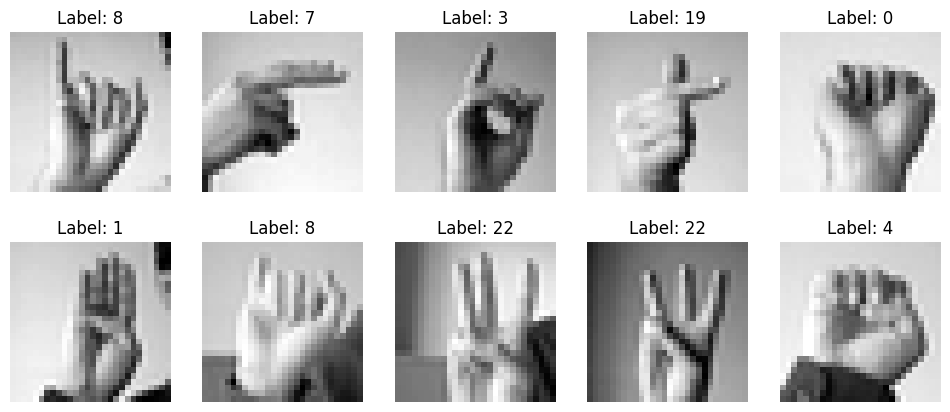

In [5]:
# Let's visualize some random training images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(len(train_df))
    label = train_df.iloc[idx, 0]
    pixels = train_df.iloc[idx, 1:].values.reshape(28, 28)
    ax.imshow(pixels, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.show()


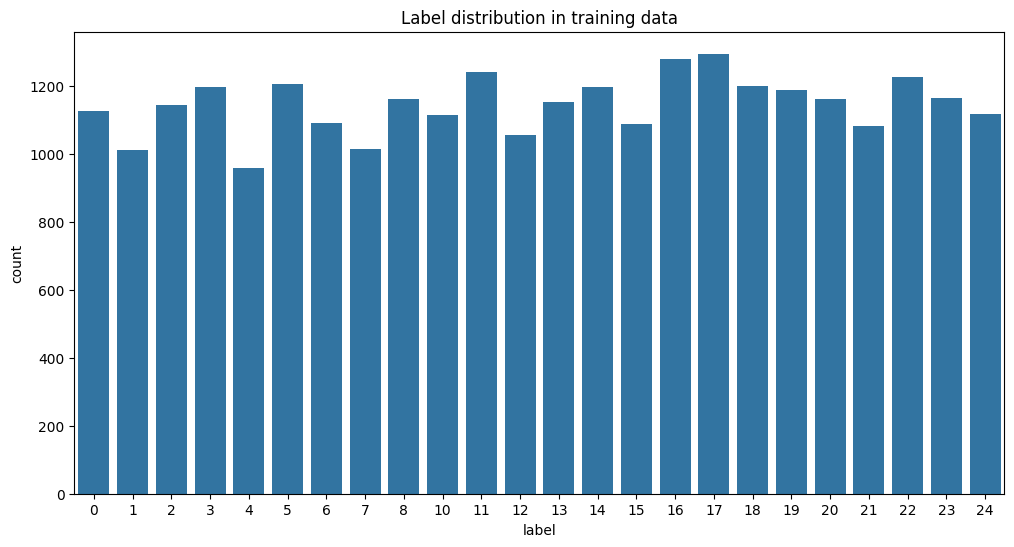

In [6]:

plt.figure(figsize=(12,6))
sns.countplot(x="label", data=train_df)
plt.title("Label distribution in training data")
plt.show()


In [7]:
# Separate labels and features
train_label = train_df['label']
trainset = train_df.drop(['label'], axis=1)

test_label = test_df['label']
testset = test_df.drop(['label'], axis=1)

# Remap labels to 0-23
def remap_label(label):
    return label - 1 if label >= 10 else label

train_label_remapped = train_label.apply(remap_label)
test_label_remapped = test_label.apply(remap_label)

# Convert to numpy arrays and reshape
X_train = trainset.values.reshape(-1, 28, 28, 1)
X_test = testset.values.reshape(-1, 28, 28, 1)

# Normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
# For PyTorch, we use class indices, not one-hot
y_train = torch.tensor(train_label_remapped.values, dtype=torch.long)
y_test = torch.tensor(test_label_remapped.values, dtype=torch.long)

# DataLoaders
train_dataset = TensorDataset(torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32), y_train)
test_dataset = TensorDataset(torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32), y_test)

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)

In [10]:
# Model definition
class SignLanguageCNN(nn.Module):
    def __init__(self):
        super(SignLanguageCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 24)  # 24 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SignLanguageCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Training
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/20], Loss: 0.7523
Epoch [2/20], Loss: 0.0376
Epoch [3/20], Loss: 0.0128
Epoch [4/20], Loss: 0.0066
Epoch [5/20], Loss: 0.0045
Epoch [6/20], Loss: 0.0044
Epoch [7/20], Loss: 0.0113
Epoch [8/20], Loss: 0.0105
Epoch [9/20], Loss: 0.0020
Epoch [10/20], Loss: 0.0014
Epoch [11/20], Loss: 0.0006
Epoch [12/20], Loss: 0.0012
Epoch [13/20], Loss: 0.0096
Epoch [14/20], Loss: 0.0040
Epoch [15/20], Loss: 0.0017
Epoch [16/20], Loss: 0.0005
Epoch [17/20], Loss: 0.0011
Epoch [18/20], Loss: 0.0009
Epoch [19/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0008


In [12]:
# Evaluation
model.eval()
correct, total = 0, 0
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

acc = correct / total
print(f"Test Accuracy: {acc:.4f}")

# Additional metrics
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# Save the model
torch.save(model.state_dict(), "sign_language_cnn.pth")

Test Accuracy: 0.9759
Precision: 0.9772
Recall: 0.9735
F1 Score: 0.9749
AUC-ROC: 0.9991


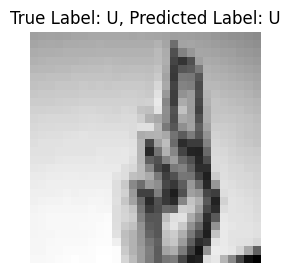

In [15]:
# Define class mapping (0-23 to A-Y, excluding J and Z)
classes = [chr(i + 65) for i in range(25) if chr(i + 65) not in ['J', 'Z']]  # A-Y, excluding J and Z

# Select a random test image
random_idx = np.random.randint(0, len(X_test) - 1)
sample_image = X_test[random_idx]  # Shape: (28, 28, 1)
true_label_idx = test_label_remapped[random_idx]
true_label = classes[true_label_idx]

# Preprocess for model (add batch and channel dimensions)
sample_tensor = torch.tensor(sample_image.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 1, 28, 28)

# Predict
model.eval()
with torch.no_grad():
    output = model(sample_tensor)
    _, pred_idx = torch.max(output, 1)
    pred_label = classes[pred_idx.item()]

# Display the image
plt.figure(figsize=(3, 3))
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.title(f"True Label: {true_label}, Predicted Label: {pred_label}")
plt.axis('off')
plt.show()